In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

In [3]:
df=pd.read_csv('daily_Queue1.csv',parse_dates=['Date'],index_col='Date')

In [4]:
df.head()

,BCST,ETS,Res_SST,Residential
Date,,,,
2017-01-01,NaN,243.0,NaN,NaN
2017-01-02,NaN,388.0,NaN,1.0
2017-01-03,829.0,878.0,2528.0,4216.0
2017-01-04,620.0,745.0,1520.0,3306.0
2017-01-05,467.0,631.0,1185.0,2406.0


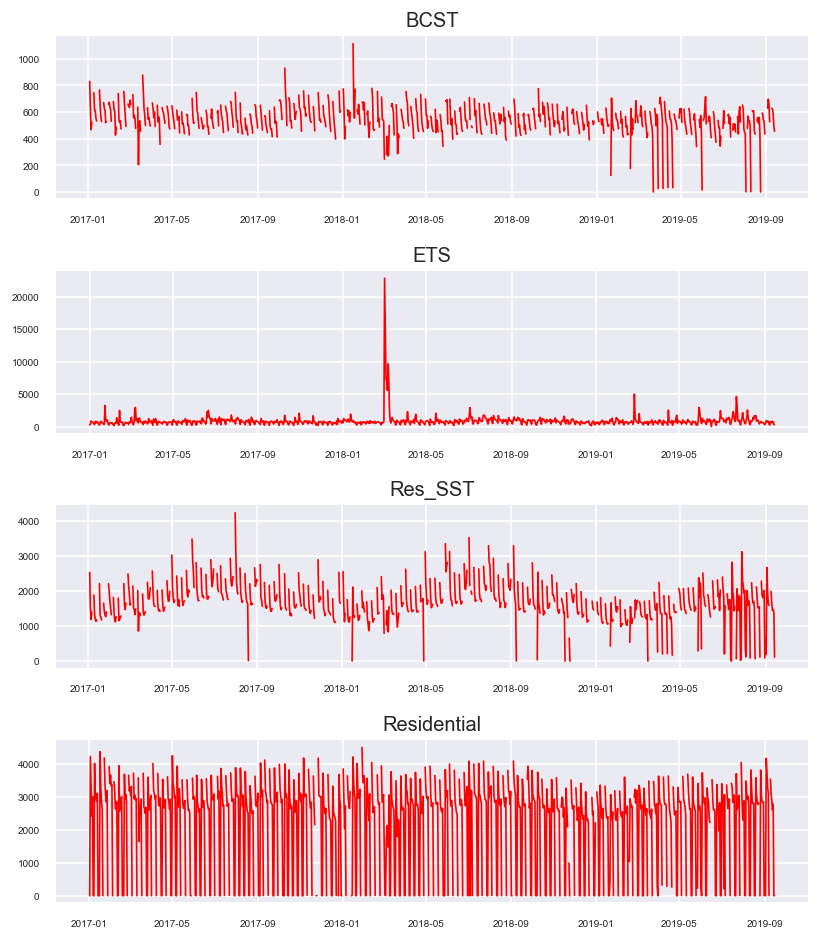

In [13]:
#plot multiple siries

fig, axes = plt.subplots(nrows=4, ncols=1, dpi=120, figsize=(7,8))  # row col
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]] #df
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])  
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

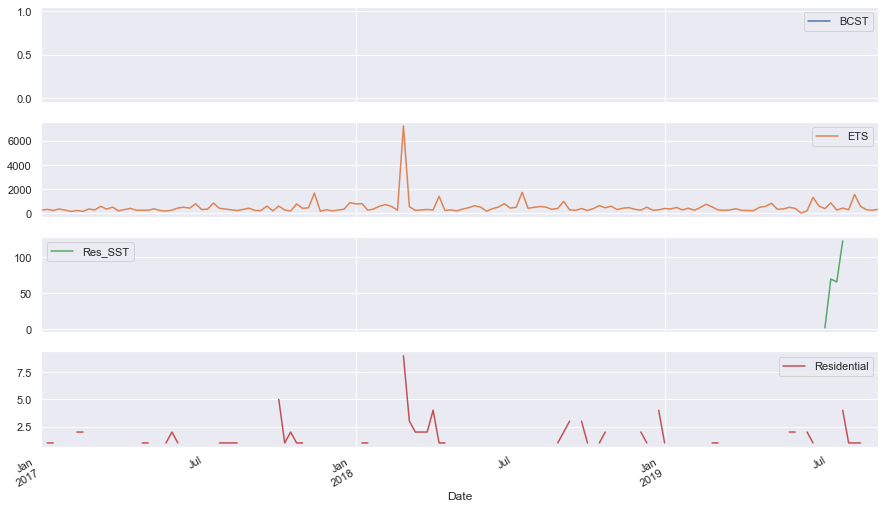

In [7]:
# look at only holiday
# ETS is in business during the whole week
# so we can analyze ETS individually
df.asfreq(freq='W').plot(subplots=True,figsize=(15, 9))
plt.show()

In [8]:
# business day
business=df.asfreq(freq='B').drop('ETS',axis=1)

In [9]:
# check missing value
# there is missing value since other holidays like individual day, Christmas
# we have to replace them with other values
business.isnull().sum()

BCST           25
Res_SST        20
Residential    10
dtype: int64

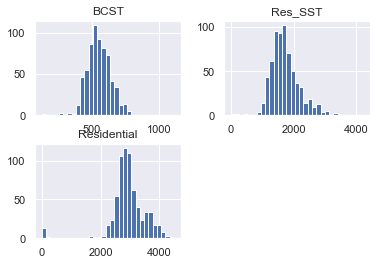

In [14]:
# EDA
bins=int(round(np.sqrt(987)))
sns.set()
business.hist(bins=bins)
plt.legend(['BCST','Res_SST','Residential'])
plt.show()

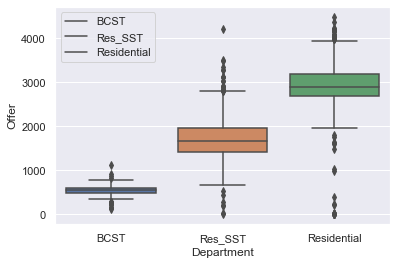

In [15]:
sns.boxplot(data=business)
plt.xlabel('Department')
plt.ylabel('Offer')
plt.legend(['BCST','Res_SST','Residential'])
plt.show()

In [16]:
# calculate IQR
IQR=business.quantile(0.75)-business.quantile(0.25)

In [17]:
# low outliers
business.quantile(0.25)-2*IQR

BCST            258.5
Res_SST         316.0
Residential    1658.5
dtype: float64

In [18]:
# high outliers
business.quantile(0.75)+2*IQR

BCST            839.75
Res_SST        3076.00
Residential    4223.50
dtype: float64

In [19]:
# treat outliers
business['BCST']=np.where((business['BCST'] <259)|
                          (business['BCST'] >840), np.nan,business['BCST'])

business['Res_SST']=np.where((business['Res_SST'] <316)|
                             (business['Res_SST'] >3022), np.nan,business['Res_SST'])

business['Residential']=np.where((business['Residential'] <1679)|
                                 (business['Residential'] >4201),np.nan,business['Residential'])

In [20]:
business.isnull().sum()

BCST           33
Res_SST        35
Residential    37
dtype: int64

In [21]:
# fill outliers
business.interpolate(method='linear',inplace=True)

In [22]:
# fill NAN
business.fillna(method='bfill',inplace=True)

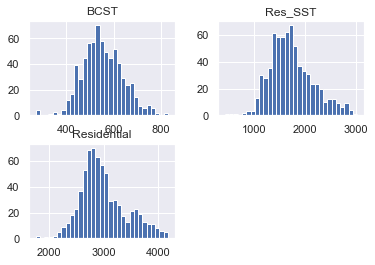

In [23]:
# the distribution looks much better than before
business.hist(bins=bins)
plt.show()

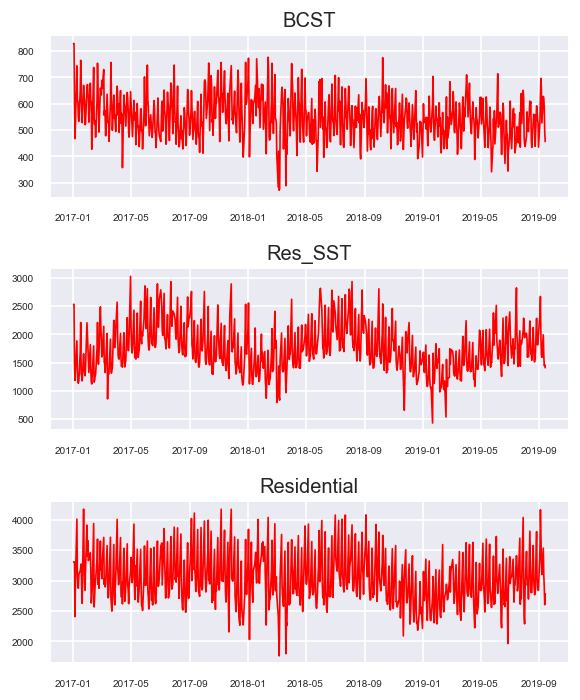

In [24]:
##plot multiple siries again
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(5,6)) 
for i, ax in enumerate(axes.flatten()):
    data = business[business.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(business.columns[i])  
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [25]:
# split training test
nobs = 90
df_train, df_test = business[0:-nobs], business[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)  

(615, 3)
(90, 3)


In [26]:
# Multi ADF function
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [27]:
# ADF Test on each column
for name, column in df_train.iteritems():   # df_train
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9568
 No. Lags Chosen       = 19
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0017. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Res_SST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3182
 No. Lags Chosen       = 19
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.6208. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Residential" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-St

In [28]:
#differencing
df_differenced = df_train.diff().dropna() 

In [29]:
# ADF Test on each column
#Now it is stationary
for name, column in df_differenced.iteritems(): # df_differenced
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2471
 No. Lags Chosen       = 18
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Res_SST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.5396
 No. Lags Chosen       = 18
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Residential" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [30]:
# import for Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=20
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [31]:
# result
# they are all good predictors
grangers_causation_matrix(business, variables = business.columns)   ##df

,BCST_x,Res_SST_x,Residential_x
BCST_y,1.0,0.0,0.0
Res_SST_y,0.0,1.0,0.0
Residential_y,0.0,0.0,1.0


In [32]:
#####Cointegration test
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [33]:
# result 
cointegration_test(business) ###df

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BCST   ::  92.37     > 24.2761   =>   True
Res_SST ::  28.36     > 12.3212   =>   True
Residential ::  0.24      > 4.1296    =>   False


In [34]:
# choose order P for AR 
# Lag Order=25 has the lowest AIC
model = VAR(df_differenced)
x= range(1,30)
for i in x:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  31.43532743133956
BIC :  31.52182070904141
FPE :  44894121913445.06
HQIC:  31.468965150193277 

Lag Order = 2
AIC :  31.020204586558975
BIC :  31.17175912566479
FPE :  29641827753108.26
HQIC:  31.079149321706193 

Lag Order = 3
AIC :  30.655509680555515
BIC :  30.872290218649045
FPE :  20583655409733.914
HQIC:  30.739829233327967 

Lag Order = 4
AIC :  30.26428348829422
BIC :  30.5464554544082
FPE :  13919374744137.3
HQIC:  30.374045950679296 

Lag Order = 5
AIC :  30.160880129301848
BIC :  30.508609647939082
FPE :  12552191823367.77
HQIC:  30.296153885647474 

Lag Order = 6
AIC :  30.14658347483868
BIC :  30.560037370023007
FPE :  12374320895951.61
HQIC:  30.307437203570885 

Lag Order = 7
AIC :  30.16061015503926
BIC :  30.639955954396637
FPE :  12549544060306.238
HQIC:  30.347112830392536 

Lag Order = 8
AIC :  30.070223381818106
BIC :  30.615629320688072
FPE :  11465503487041.014
HQIC:  30.28244427557864 

Lag Order = 9
AIC :  29.888773930332476
BIC :  30.50040

In [35]:
# fit model
model_fitted = model.fit(25)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Jul, 2020
Time:                     17:00:45
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    31.4252
Nobs:                     589.000    HQIC:                   30.3906
Log likelihood:          -11034.8    FPE:                8.19585e+12
AIC:                      29.7303    Det(Omega_mle):     5.69476e+12
--------------------------------------------------------------------
Results for equation BCST
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.889324         2.480269           -0.359           0.720
L1.BCST                -0.679795         0.055318          -12.289           0.000
L1.Res_SST              0.012561         0.013932    

In [36]:
##Durbin-Watson Statistic: 
#Serial Correlation of Residuals (1.5-2.5) close to 2, better
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out): # df_diff
    print((col), ':', round(val, 2))

BCST : 2.0
Res_SST : 2.01
Residential : 2.0


In [37]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

25


In [38]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 128.,  508.,  852.],
       [ -90., -445., -691.],
       [ -56.,  -82., -133.],
       [ -21.,   20.,   20.],
       [ -25.,   -9.,  -64.],
       [ 121.,  505.,  901.],
       [ -60., -487., -738.],
       [  -3., -159., -309.],
       [ -29.,   55., -160.],
       [-127., -185., -197.],
       [ 197.,  540., 1074.],
       [ -38., -198., -550.],
       [ -11.,  -35., -296.],
       [ -23.,   18.,   67.],
       [ -43.,  -18.,   50.],
       [  84.,  687.,  714.],
       [  70.,  -36., -378.],
       [ -27., -135.,  -69.],
       [  28., -338.,    4.],
       [-102., -104.,   15.],
       [  97.,  607.,  760.],
       [ -79., -442., -663.],
       [ -33., -167., -131.],
       [ -35.,  -18., -118.],
       [ -39.,  -81., -220.]])

In [39]:
# Forecast
fc = model_fitted.forecast(y=forecast_input,steps=nobs)
df_forecast = pd.DataFrame(fc, index=business.index[-nobs:], columns=business.columns) #df
df_forecast.head()

,BCST,Res_SST,Residential
Date,,,
2019-05-13,165.379557,550.466414,949.644301
2019-05-14,-50.367473,-457.030921,-590.907992
2019-05-15,-8.814766,-91.895469,-155.694201
2019-05-16,-43.375826,-131.216685,-152.274732
2019-05-17,-64.463877,-47.055768,-19.842627


In [40]:
df_train.iloc[-1]

BCST            434.0
Res_SST        1358.0
Residential    2482.0
Name: 2019-05-10 00:00:00, dtype: float64

In [41]:
# transform to original
df_forecast.BCST=df_forecast.BCST.cumsum()+434
df_forecast.Res_SST=df_forecast.Res_SST.cumsum()+1358
df_forecast.Residential=df_forecast.Residential.cumsum()+2482

In [42]:
# Evaluation
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [43]:
print('Forecast Accuracy of: BCST')
accuracy_prod = forecast_accuracy(df_forecast['BCST'].values, df_test['BCST']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: BCST
mape :  0.0977
me :  1.8703
mae :  50.2815
mpe :  0.0182
rmse :  63.1531
corr :  0.5629
minmax :  0.0892


In [44]:
print('Forecast Accuracy of: Res_SST')
accuracy_prod = forecast_accuracy(df_forecast['Res_SST'].values, df_test['Res_SST']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Res_SST
mape :  0.1398
me :  -262.1837
mae :  269.9917
mpe :  -0.1347
rmse :  332.1653
corr :  0.7564
minmax :  0.1397


In [45]:
print('Forecast Accuracy of: Residential')
accuracy_prod = forecast_accuracy(df_forecast['Residential'].values, df_test['Residential'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Residential
mape :  0.087
me :  -206.6328
mae :  268.9656
mpe :  -0.0604
rmse :  346.7682
corr :  0.7271
minmax :  0.0851


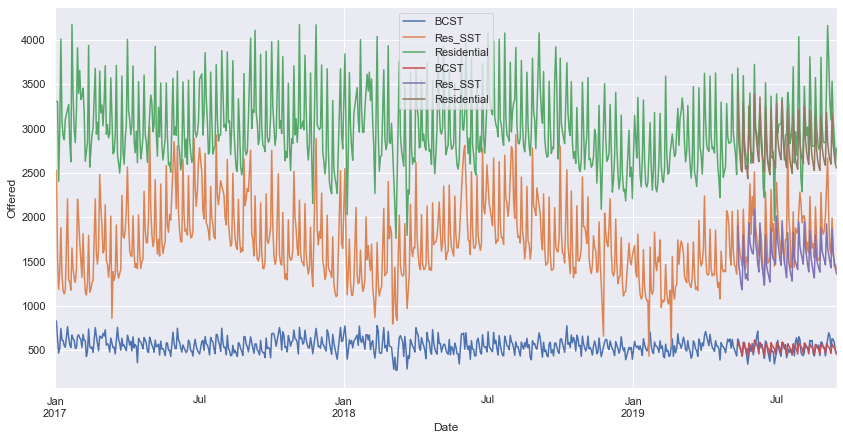

In [46]:
# visualize forecast
ax = business.plot(label='observed', figsize=(14, 7))
df_forecast.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Offered')
plt.legend()
plt.show()

# ETS—Preprocessing

In [66]:
ETS=df[['ETS']]
ETS.isnull().sum()

ETS    0
dtype: int64

In [67]:
ETS.head()

,ETS
Date,
2017-01-01,243.0
2017-01-02,388.0
2017-01-03,878.0
2017-01-04,745.0
2017-01-05,631.0


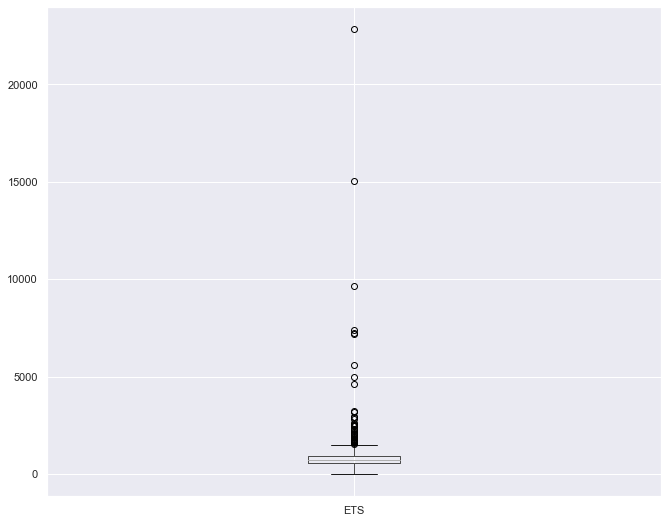

In [68]:
sns.set()
ETS.boxplot()
plt.show()

In [69]:
IQR=np.percentile(ETS,75)-np.percentile(ETS,25)
thresh=np.percentile(ETS,75)+2*IQR
ETS[ETS>thresh]=np.nan
ETS.interpolate(method='linear',inplace=True)
ETS.fillna(method='bfill',inplace=True)

/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

In [70]:
nobs = 90
df_train, df_test = ETS[0:-nobs], ETS[-nobs:]

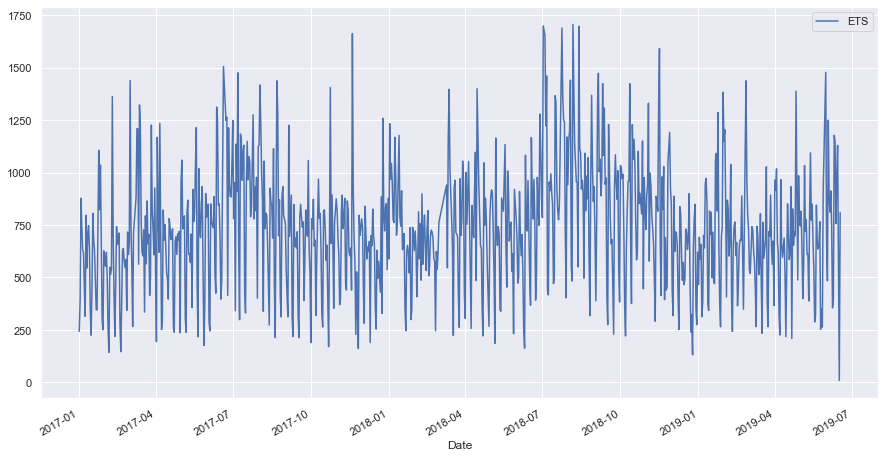

In [71]:
df_train.plot(figsize=(15,8))

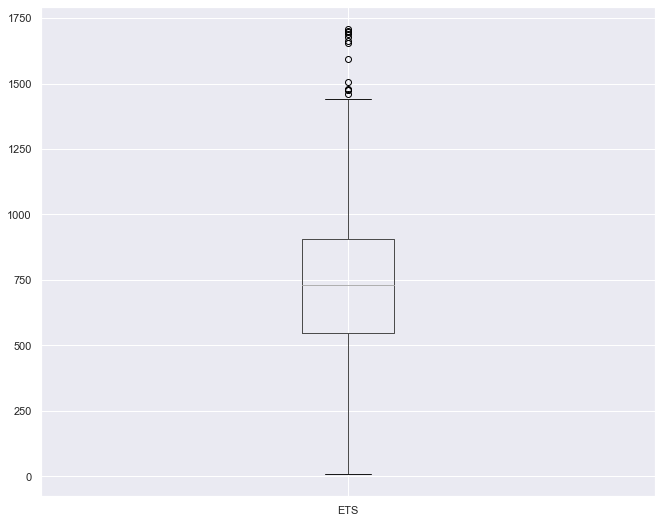

In [72]:
df_train.boxplot()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x105823a50>]],
      dtype=object)

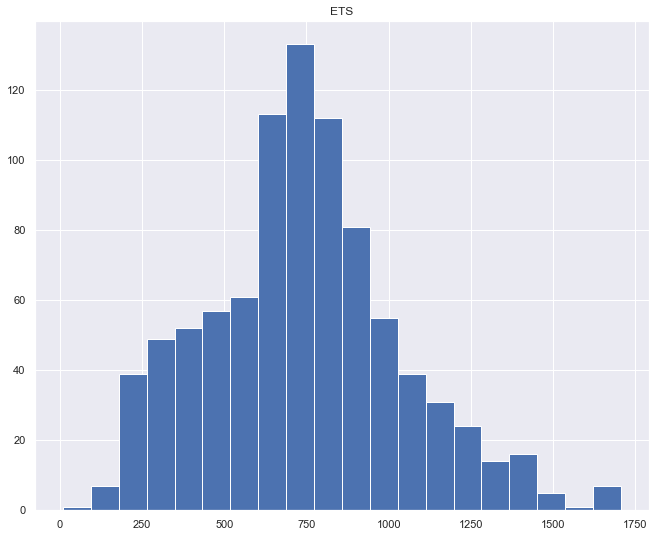

In [73]:
df_train.hist(bins=20)

In [74]:
# ADF Test
print(adfuller(df_train)[1])

0.009235726082343881


In [75]:
df_train.shape

(897, 1)

/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


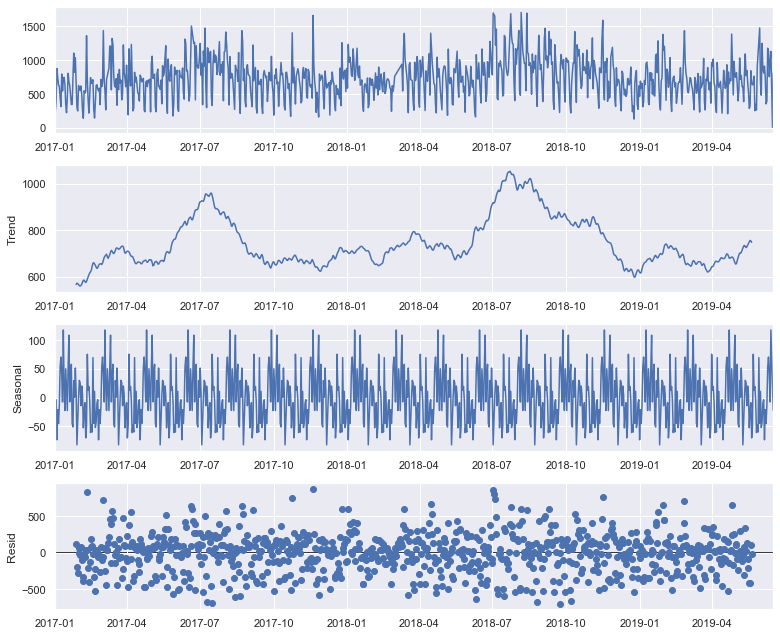

In [62]:
rcParams['figure.figsize']= 11,9
decomposition= sm.tsa.seasonal_decompose(df_train,freq=52)
fig=decomposition.plot()
plt.show()

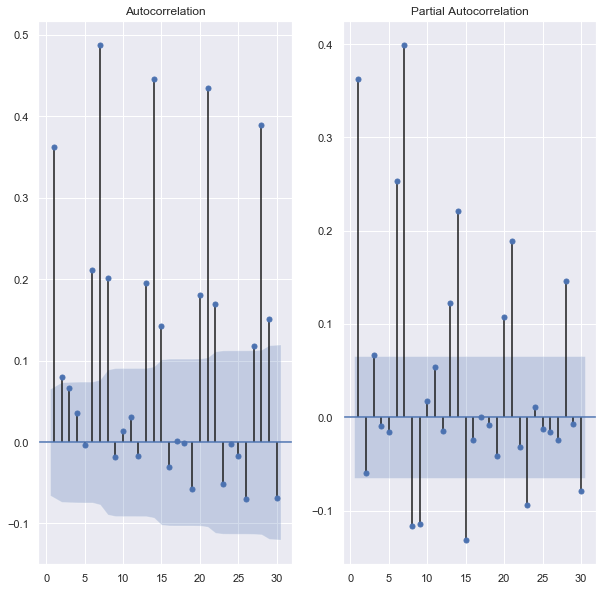

In [76]:
# seasonality=7

# Creat figure
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))
# Make ACF
plot_acf(df_train,zero=False,ax=ax1)
# Make PACF
plot_pacf(df_train,zero=False,ax=ax2)
plt.show()

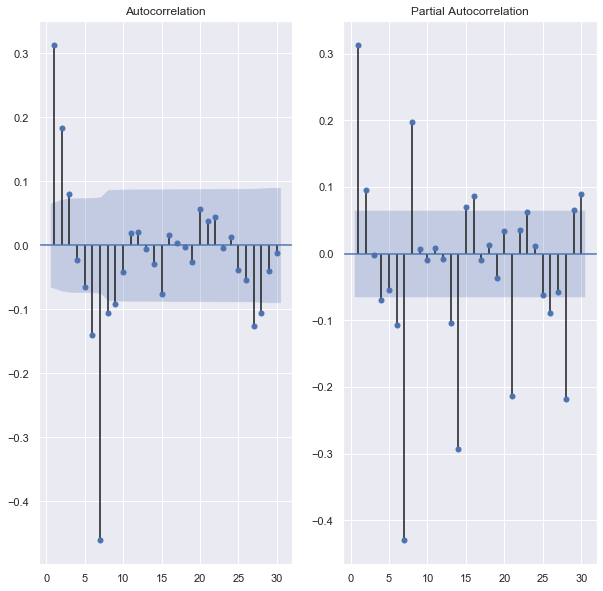

In [77]:
#  Deseasonality
# it seems that there is a seaonality in lag 27
# so,we have to separate weekday and weekend

# Creat figure
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))
# Make ACF
plot_acf(df_train.diff(7).dropna(),zero=False,ax=ax1)
# Make PACF
plot_pacf(df_train.diff(7).dropna(),zero=False,ax=ax2)
plt.show()

In [78]:
# extract Business day
ETS_Business=df[['ETS']].asfreq('B')

In [79]:
ETS_Business.isna().sum()

ETS    0
dtype: int64

In [80]:
ETS_Business

,ETS
Date,
2017-01-02,388.0
2017-01-03,878.0
2017-01-04,745.0
2017-01-05,631.0
2017-01-06,618.0
...,...
2019-09-09,793.0
2019-09-10,589.0
2019-09-11,646.0


In [81]:
IQR=ETS_Business.quantile(0.75)-ETS_Business.quantile(0.25)
ETS_Business[(ETS_Business>2.0*IQR+ETS_Business.quantile(0.75)) | 
             (ETS_Business<ETS_Business.quantile(0.25)-2.0*IQR)]=np.nan
ETS_Business.head()

,ETS
Date,
2017-01-02,388.0
2017-01-03,878.0
2017-01-04,745.0
2017-01-05,631.0
2017-01-06,618.0


In [90]:
ETS_Business.interpolate(method='linear').fillna(method='bfill',inplace=True)

In [91]:
assert ETS_Business.notnull().all().all()

In [92]:
nobs=90
ETS_train,ETS_test=ETS_Business[:-nobs],ETS[-nobs:]

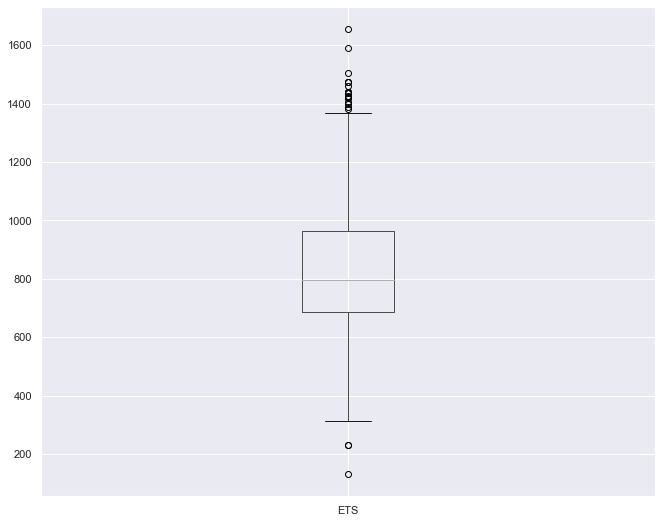

In [93]:
ETS_train.boxplot()

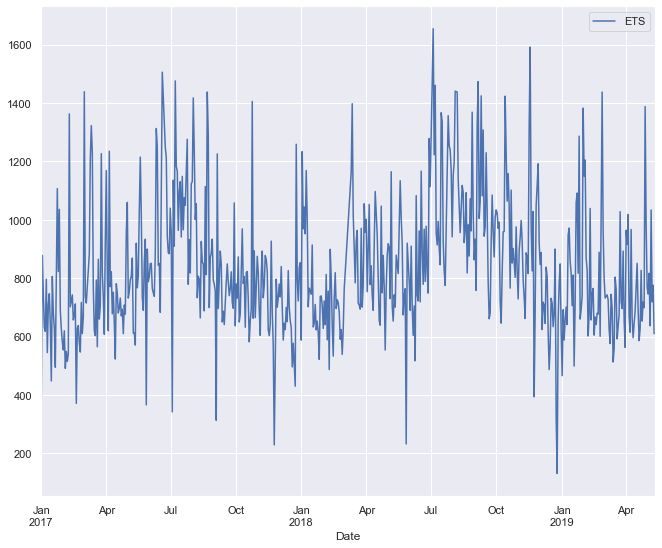

In [95]:
ETS_train.plot()

/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


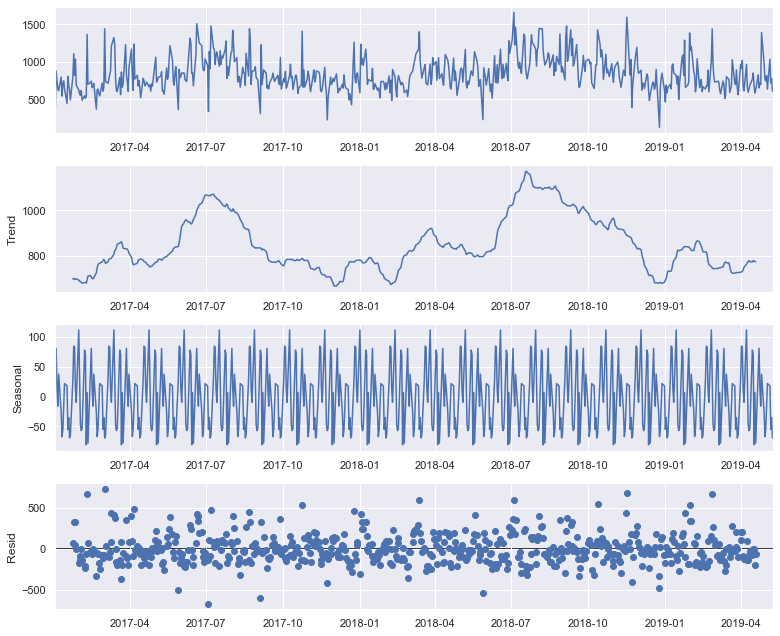

In [96]:
rcParams['figure.figsize']= 11,9
decomposition= sm.tsa.seasonal_decompose(ETS_train,freq=30)
fig=decomposition.plot()
plt.show()

In [97]:
adfuller(ETS_train)[1]

2.139412857646438e-05

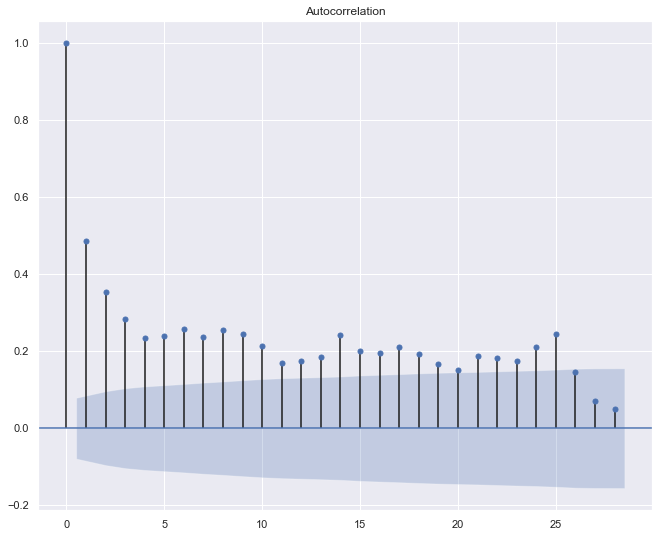

In [98]:
plot_acf(ETS_train)
plt.show()

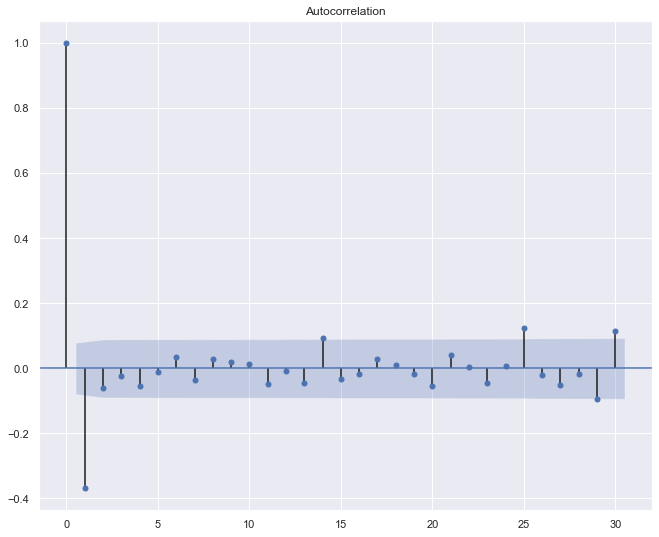

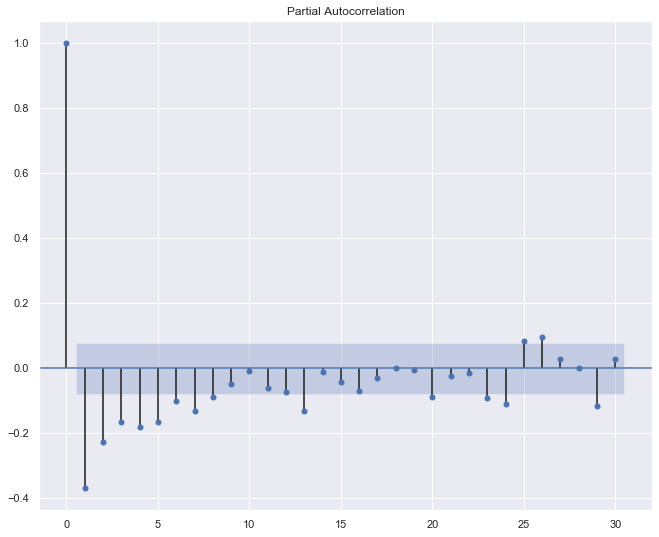

In [99]:
# too many lags in PACF
# It seems not a good idea to predict with SARIMA
plot_acf(ETS_train.diff(1).dropna(),lags=30)
plot_pacf(ETS_train.diff(1).dropna(),lags=30)
plt.show()

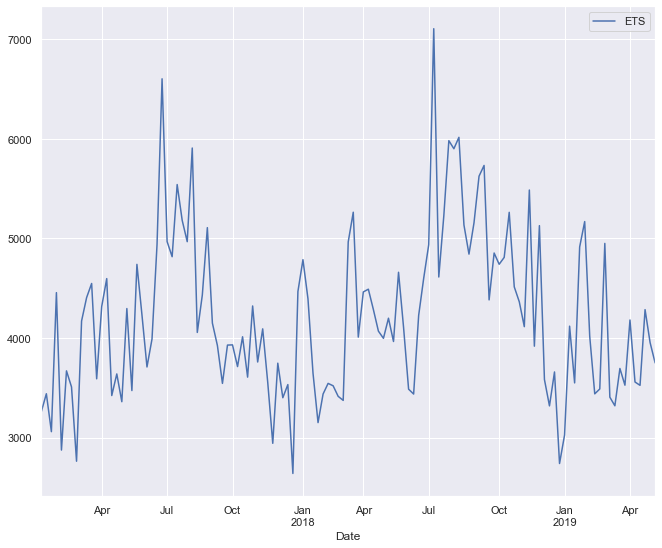

In [100]:
# if we resample into week, It has an obvious seanality
# But we are required to predict on daily bases
# just keep it in mind
ETS_train.resample('W').sum().plot()

In [101]:
import pmdarima as pm
results=pm.auto_arima(ETS_train,d=1,start_p=0,start_q=1,max_p=1,max_q=2,
                      seasonal=False,m=7,D=0,start_P=0,Start_Q=0,max_P=1,max_Q=1,
                     information_criterion='aic',trace=True,erro_action='ignore',stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8269.598, BIC=8282.858, Time=0.296 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8442.809, BIC=8451.649, Time=0.024 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=8355.100, BIC=8368.360, Time=0.150 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=8440.811, BIC=8445.231, Time=0.014 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8233.411, BIC=8251.091, Time=0.265 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=8234.414, BIC=8256.514, Time=0.525 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=8239.790, BIC=8257.470, Time=0.304 seconds
Total fit time: 1.582 seconds


In [102]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(endog=ETS_train,order=(1, 1, 1))  #value                                
results = mod.fit()

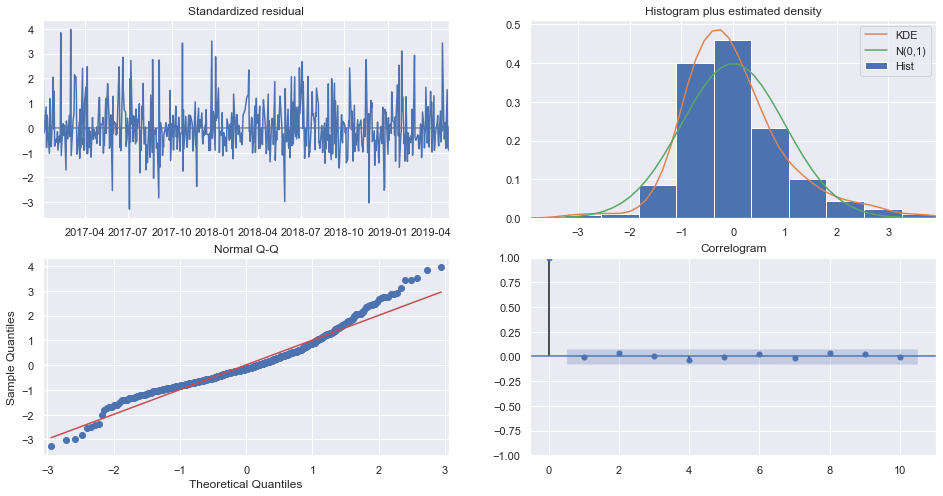

In [103]:
#plot diagnostics
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [104]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    ETS   No. Observations:                  615
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4112.719
Date:                Fri, 17 Jul 2020   AIC                           8231.439
Time:                        21:33:03   BIC                           8244.699
Sample:                    01-02-2017   HQIC                          8236.595
                         - 05-10-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3047      0.043      7.162      0.000       0.221       0.388
ma.L1         -0.9216      0.019    -48.329      0.000      -0.959      -0.884
sigma2      3.841e+04   1605.719     23.923      0.0

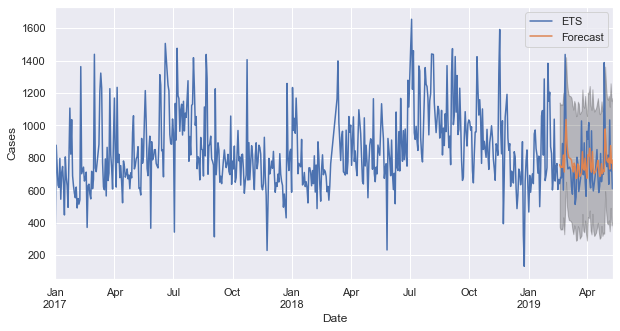

In [105]:
# on step ahead
pred=results.get_prediction(start=-60,dynamic=False)
pred_mean=pred.predicted_mean
pred_ci=pred.conf_int()

ax = ETS_train.plot(label='observed', figsize=(10, 5)) #value
pred_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
plt.legend()
plt.show()

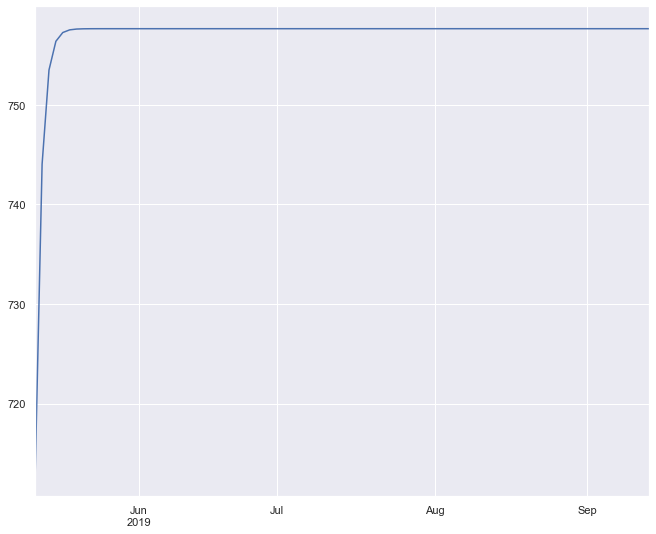

In [106]:
# Not good
results.forecast(steps=90).plot()

In [113]:
print('Forecast Accuracy of: ETS')
accuracy_prod = forecast_accuracy(results.forecast(steps=90), ETS_test.ETS) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: ETS
mape :  0.2425
me :  -229.6254
mae :  269.3498
mpe :  -0.1769
rmse :  345.8265
corr :  0.0158
minmax :  0.2977


# Preprocessing Train & Test Seprately

In [115]:
# extract Business day
Business=df.asfreq('B')
Business.head()

,BCST,ETS,Res_SST,Residential
Date,,,,
2017-01-02,NaN,388.0,NaN,1.0
2017-01-03,829.0,878.0,2528.0,4216.0
2017-01-04,620.0,745.0,1520.0,3306.0
2017-01-05,467.0,631.0,1185.0,2406.0
2017-01-06,523.0,618.0,1396.0,3004.0


In [7]:
# train and test
nobs=90
df_train, df_test= Business[:-nobs],Business[-nobs:]

In [8]:
df_test.shape

(90, 4)

In [9]:
df_train.shape

(615, 4)

In [10]:
# replace outlierS with NAN
IQR=df_train.quantile(0.75)-df_train.quantile(0.25)
df_train[(df_train>2.0*IQR+df_train.quantile(0.75)) | (df_train<df_train.quantile(0.25)-2.0*IQR)]=np.nan
df_train.head()

/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


,BCST,ETS,Res_SST,Residential
Date,,,,
2017-01-02,NaN,388.0,NaN,NaN
2017-01-03,829.0,878.0,2528.0,4216.0
2017-01-04,620.0,745.0,1520.0,3306.0
2017-01-05,467.0,631.0,1185.0,2406.0
2017-01-06,523.0,618.0,1396.0,3004.0


In [11]:
df_train.isna().sum()

BCST           30
ETS            31
Res_SST        30
Residential    32
dtype: int64

In [12]:
# fill missing value
df_train.interpolate(method='linear',inplace=True)
df_train.fillna(method='bfill',inplace=True)

/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [13]:
# Assert that there are no misssing value
assert pd.notnull(df_train).all().all()

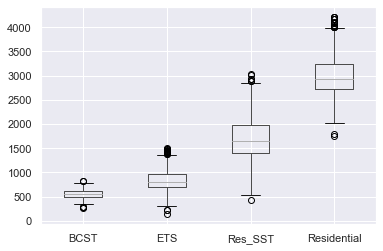

In [14]:
# boxplot
# looks very good
sns.set()
df_train.boxplot()
plt.show()

In [15]:
# there are missing value in test data
# we have to replace it 
df_test.isnull().sum()

BCST           3
ETS            0
Res_SST        0
Residential    0
dtype: int64

In [16]:
# Replace missing value 
df_test.interpolate(method='linear',inplace=True)

/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
df_diff=df_train.diff().dropna().drop('ETS',axis=1)

In [20]:
for name, column in df_diff.iteritems(): # df_differenced
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2471
 No. Lags Chosen       = 18
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Res_SST" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.6755
 No. Lags Chosen       = 18
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Residential" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [24]:
# EST is not a good predictor for Residential and SST
grangers_causation_matrix(df_diff, variables = df_diff.columns)   ##df

,BCST_x,Res_SST_x,Residential_x
BCST_y,1.0,0.0,0.0
Res_SST_y,0.0,1.0,0.0
Residential_y,0.0,0.0,1.0


In [25]:
model = VAR(df_diff)
x= range(1,30)
for i in x:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  31.403543849157835
BIC :  31.490037126859686
FPE :  43489663489545.36
HQIC:  31.437181568011553 

Lag Order = 2
AIC :  31.03987600329006
BIC :  31.191430542395874
FPE :  30230697461032.95
HQIC:  31.09882073843728 

Lag Order = 3
AIC :  30.66951317773911
BIC :  30.88629371583264
FPE :  20873926230156.844
HQIC:  30.75383273051156 

Lag Order = 4
AIC :  30.28700225162739
BIC :  30.569174217741367
FPE :  14239225271668.734
HQIC:  30.396764714012463 

Lag Order = 5
AIC :  30.194674871385576
BIC :  30.54240439002281
FPE :  12983639172908.238
HQIC:  30.329948627731202 

Lag Order = 6
AIC :  30.17728746660236
BIC :  30.590741361786687
FPE :  12760154954567.764
HQIC:  30.338141195334565 

Lag Order = 7
AIC :  30.193174078920684
BIC :  30.67251987827806
FPE :  12964933100157.621
HQIC:  30.37967675427396 

Lag Order = 8
AIC :  30.104758699312573
BIC :  30.650164638182538
FPE :  11868385070011.814
HQIC:  30.316979593073107 

Lag Order = 9
AIC :  29.922748852708487
BIC :  30.53

In [26]:
# fit model
model_fitted = model.fit(25)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Jul, 2020
Time:                     11:15:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    31.4151
Nobs:                     589.000    HQIC:                   30.3805
Log likelihood:          -11031.9    FPE:                8.11327e+12
AIC:                      29.7202    Det(Omega_mle):     5.63737e+12
--------------------------------------------------------------------
Results for equation BCST
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.805686         2.484405           -0.324           0.746
L1.BCST                -0.680985         0.054726          -12.443           0.000
L1.Res_SST              0.010218         0.014133    

In [27]:
# close to 2.0
# Residuals do not have autocorrelation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_diff.columns, out): # df_diff
    print((col), ':', round(val, 2))

BCST : 2.0
Res_SST : 2.01
Residential : 2.01


In [28]:
# forecast
lag_order = model_fitted.k_ar
forecast_input = df_diff.values #df
fc = model_fitted.forecast(y=forecast_input,steps=90)
df_forecast = pd.DataFrame(fc, index=df_test.index[-90:], columns=df_diff.columns) #df
df_forecast.head()

,BCST,Res_SST,Residential
Date,,,
2019-05-13,168.115703,546.814500,940.295187
2019-05-14,-54.536115,-464.654628,-596.120082
2019-05-15,-12.282470,-93.085654,-146.759411
2019-05-16,-40.054223,-127.997957,-145.620768
2019-05-17,-59.379334,-36.785933,-28.069166


In [36]:
pred=df_forecast.cumsum()+df_train.drop('ETS',axis=1).iloc[-1]
pred

,BCST,Res_SST,Residential
Date,,,
2019-05-13,602.115703,1904.814500,3422.295187
2019-05-14,547.579588,1440.159872,2826.175105
2019-05-15,535.297118,1347.074218,2679.415694
2019-05-16,495.242895,1219.076261,2533.794926
2019-05-17,435.863561,1182.290327,2505.725760
...,...,...,...
2019-09-09,569.858496,1864.580661,3169.496948
2019-09-10,539.247277,1568.382525,2798.153845
2019-09-11,528.547089,1506.555730,2699.752900


In [406]:
print('Forecast Accuracy of: ETS')
accuracy_prod = forecast_accuracy(pred['ETS'], df_test['ETS']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: ETS
mape :  0.2767
me :  -327.7426
mae :  388.6629
mpe :  -0.1529
rmse :  707.8338
corr :  0.1136
minmax :  0.2538


In [37]:
print('Forecast Accuracy of: BCST')
accuracy_prod = forecast_accuracy(pred['BCST'], df_test['BCST']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: BCST
mape :  0.0985
me :  2.0523
mae :  50.6102
mpe :  0.0187
rmse :  63.4254
corr :  0.5576
minmax :  0.0898


In [38]:
print('Forecast Accuracy of: Res_SST')
accuracy_prod = forecast_accuracy(pred['Res_SST'], df_test['Res_SST']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Res_SST
mape :  0.3777
me :  -216.8579
mae :  329.0916
mpe :  0.1004
rmse :  455.223
corr :  0.4132
minmax :  0.1701


In [40]:
print('Forecast Accuracy of: Residential')
accuracy_prod = forecast_accuracy(pred['Residential'], df_test['Residential']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Residential
mape :  35.7091
me :  -108.8403
mae :  356.9486
mpe :  35.5649
rmse :  632.6958
corr :  0.2896
minmax :  0.1142


# result: it seems that we should treat the outliers together in train and test sets

In [122]:
Business=df.asfreq('B')

In [123]:
# replace outlierS with NAN
IQR=Business.quantile(0.75)-Business.quantile(0.25)
Business[(Business>2.0*IQR+Business.quantile(0.75)) | (Business<Business.quantile(0.25)-2.0*IQR)]=np.nan
Business.head()

,BCST,ETS,Res_SST,Residential
Date,,,,
2017-01-02,NaN,388.0,NaN,NaN
2017-01-03,829.0,878.0,2528.0,4216.0
2017-01-04,620.0,745.0,1520.0,3306.0
2017-01-05,467.0,631.0,1185.0,2406.0
2017-01-06,523.0,618.0,1396.0,3004.0


In [124]:
# fill missing value
Business.interpolate(method='linear',inplace=True)
Business.fillna(method='bfill',inplace=True)

In [125]:
# train and test
nobs=90
df_train, df_test= Business[:-nobs],Business[-nobs:]

In [126]:
df_diff=df_train.diff().dropna()
df_diff

,BCST,ETS,Res_SST,Residential
Date,,,,
2017-01-03,0.0,490.0,0.0,0.0
2017-01-04,-209.0,-133.0,-1008.0,-910.0
2017-01-05,-153.0,-114.0,-335.0,-900.0
2017-01-06,56.0,-13.0,211.0,598.0
2017-01-09,221.0,179.0,486.0,1006.0
...,...,...,...,...
2019-05-06,97.0,397.0,607.0,760.0
2019-05-07,-79.0,-315.0,-442.0,-663.0
2019-05-08,-33.0,57.0,-167.0,-131.0


In [127]:
# ETS is not a good predictor for Res_SST and BCST 
grangers_causation_matrix(df_diff, variables = df_diff.columns)

,BCST_x,ETS_x,Res_SST_x,Residential_x
BCST_y,1.0000,0.3000,0.0000,0.0000
ETS_y,0.0301,1.0000,0.0158,0.0021
Res_SST_y,0.0000,0.0902,1.0000,0.0000
Residential_y,0.0000,0.0056,0.0000,1.0000


In [128]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
# result 
cointegration_test(df_diff) ###df

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BCST   ::  754.41    > 40.1749   =>   True
ETS    ::  526.91    > 24.2761   =>   True
Res_SST ::  317.69    > 12.3212   =>   True
Residential ::  138.44    > 4.1296    =>   True


In [129]:
model = VAR(df_diff)
x= range(1,30)
for i in x:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  42.100319928998644
BIC :  42.24447539183506
FPE :  1.9228139311630377e+18
HQIC:  42.15638279375484 

Lag Order = 2
AIC :  41.702892224188496
BIC :  41.96270000551275
FPE :  1.29222951438585e+18
HQIC:  41.803940341583726 

Lag Order = 3
AIC :  41.323349571987066
BIC :  41.69910250468252
FPE :  8.841253655309174e+17
HQIC:  41.46950346345932 

Lag Order = 4
AIC :  40.941037269752904
BIC :  41.43302941579779
FPE :  6.032421078559828e+17
HQIC:  41.132417973398674 

Lag Order = 5
AIC :  40.827175594146304
BIC :  41.43570225176146
FPE :  5.383498438549335e+17
HQIC:  41.06390466775115 

Lag Order = 6
AIC :  40.818897192077685
BIC :  41.544254902927385
FPE :  5.339522267379971e+17
HQIC:  41.10109671616927 

Lag Order = 7
AIC :  40.83131903776094
BIC :  41.67380559420724
FPE :  5.406833720434657e+17
HQIC:  41.159111618684875 

Lag Order = 8
AIC :  40.75591841349611
BIC :  41.71583286590725
FPE :  5.014848536640394e+17
HQIC:  41.129427186514654 

Lag Order = 9
AIC :  40.58707

In [130]:
# fit model
model_fitted = model.fit(28)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Jul, 2020
Time:                     21:42:59
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    43.8450
Nobs:                     586.000    HQIC:                   41.7863
Log likelihood:          -14732.2    FPE:                3.84717e+17
AIC:                      40.4717    Det(Omega_mle):     1.90031e+17
--------------------------------------------------------------------
Results for equation BCST
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.628123         2.508943           -0.250           0.802
L1.BCST                -0.659983         0.057726          -11.433           0.000
L1.ETS                 -0.018193         0.014351    

In [131]:
lag_order = model_fitted.k_ar
forecast_input = df_diff.values #df
fc = model_fitted.forecast(y=forecast_input,steps=90)
df_forecast = pd.DataFrame(fc, index=df_test.index[-90:], columns=df_diff.columns) #df
df_forecast.head()

,BCST,ETS,Res_SST,Residential
Date,,,,
2019-05-13,178.876090,72.114391,613.107755,1003.396365
2019-05-14,-46.970672,81.287547,-406.509735,-604.442351
2019-05-15,-9.744334,-4.396802,-123.840824,-270.512010
2019-05-16,-51.845366,90.572643,-61.507220,8.665624
2019-05-17,-46.381093,-107.003665,-96.429846,-70.543485


In [132]:
pred=df_train.iloc[-1]+df_forecast.cumsum()
pred.head()

,BCST,ETS,Res_SST,Residential
Date,,,,
2019-05-13,612.876090,683.114391,1971.107755,3485.396365
2019-05-14,565.905418,764.401938,1564.598019,2880.954014
2019-05-15,556.161085,760.005136,1440.757196,2610.442004
2019-05-16,504.315718,850.577779,1379.249976,2619.107628
2019-05-17,457.934625,743.574113,1282.820130,2548.564143


In [133]:
print('Forecast Accuracy of: ETS')
accuracy_prod = forecast_accuracy(pred['ETS'], df_test['ETS']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: ETS
mape :  0.2377
me :  -161.6014
mae :  232.8354
mpe :  -0.0972
rmse :  297.5915
corr :  0.1705
minmax :  0.2116


In [134]:
print('Forecast Accuracy of: BCST')
accuracy_prod = forecast_accuracy(pred['BCST'], df_test['BCST']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: BCST
mape :  0.0987
me :  6.4846
mae :  50.2418
mpe :  0.0269
rmse :  63.8879
corr :  0.557
minmax :  0.0891


In [135]:
print('Forecast Accuracy of: Res_SST')
accuracy_prod = forecast_accuracy(pred['Res_SST'], df_test['Res_SST']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Res_SST
mape :  0.1082
me :  -181.4218
mae :  208.0682
mpe :  -0.0908
rmse :  264.0277
corr :  0.7867
minmax :  0.1075


In [136]:
print('Forecast Accuracy of: Residential')
accuracy_prod = forecast_accuracy(pred['Residential'], df_test['Residential']) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Residential
mape :  0.0847
me :  -197.8147
mae :  260.2066
mpe :  -0.058
rmse :  338.2348
corr :  0.7329
minmax :  0.0828


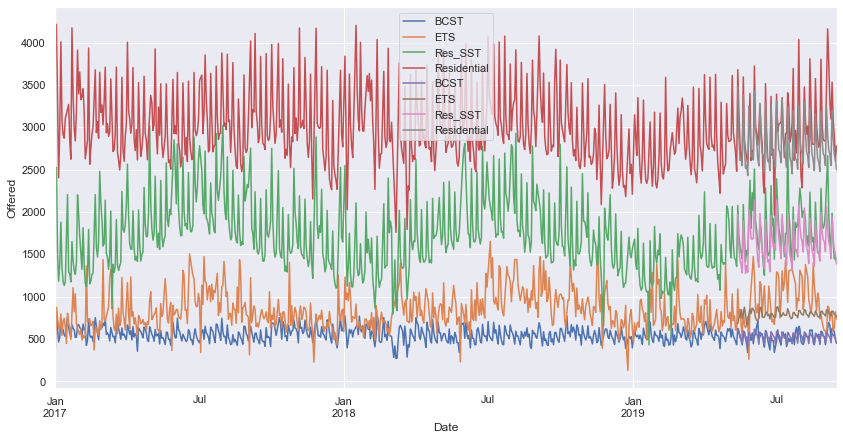

In [138]:
# visualize forecast
# ETS is not good
ax = Business.plot(label='observed', figsize=(14, 7))
pred.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Offered')
plt.legend()
plt.show()

# Forecast ETS Weekend

In [142]:
SAT=df[['ETS']].asfreq('W-SAT')
SUN=df[['ETS']].asfreq('W-SUN')
Weekend=pd.concat([SUN,SAT],axis=0).sort_index(ascending=True)
Weekend.head()

,ETS
Date,
2017-01-01,243.0
2017-01-07,453.0
2017-01-08,315.0
2017-01-14,344.0
2017-01-15,225.0


In [143]:
Weekend.isnull().sum()

ETS    1
dtype: int64

In [144]:
def replace_outlier(data):
    IQR=data.quantile(0.75)-data.quantile(0.25)
    data[(data>2.0*IQR+data.quantile(0.75)) | (data<data.quantile(0.25)-2.0*IQR)]=np.nan
    data.interpolate(method='linear',inplace=True)
    data.fillna(method='bfill',inplace=True)

In [145]:
replace_outlier(Weekend)

In [150]:
assert Weekend.notnull().all().all()

In [228]:
nobs=30
df_train,df_test=Weekend[:-30],Weekend[-30:]

In [229]:
df_train.shape

(253, 1)

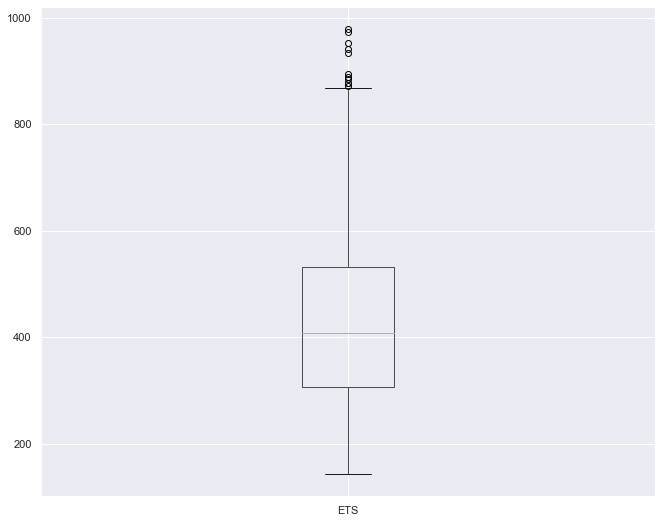

In [230]:
# Looks good
df_train.boxplot()
plt.show()

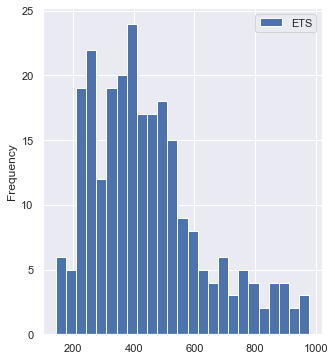

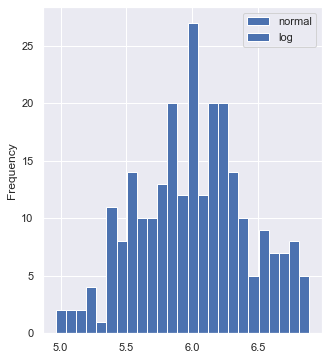

In [232]:
df_train.plot(kind='hist',figsize=(5,6),bins=25)
np.log(df_train).plot(kind='hist',figsize=(5,6),bins=25)
plt.legend(['normal','log'])
plt.show()

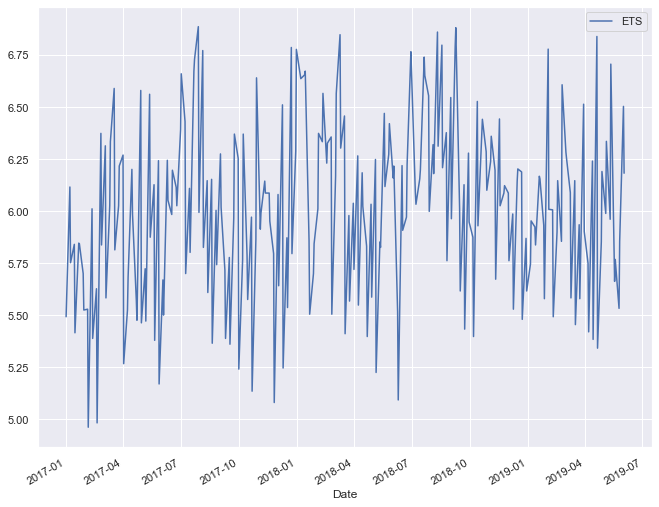

In [233]:
np.log(df_train).plot()

In [234]:
adfuller(np.log(df_train))[1]

2.985275295533833e-07

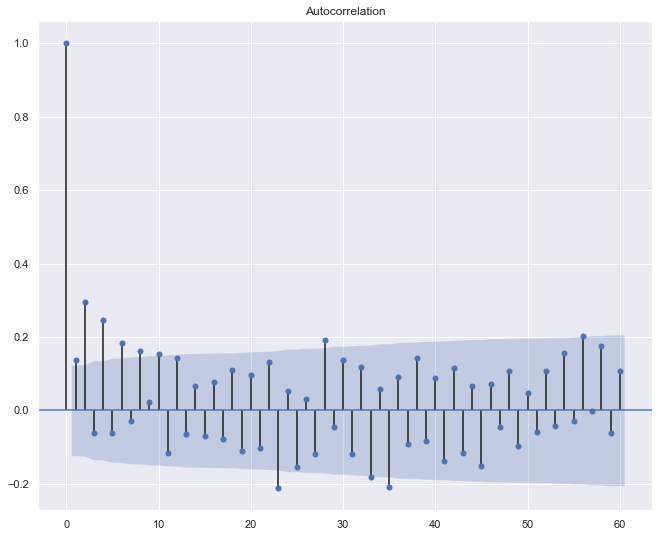

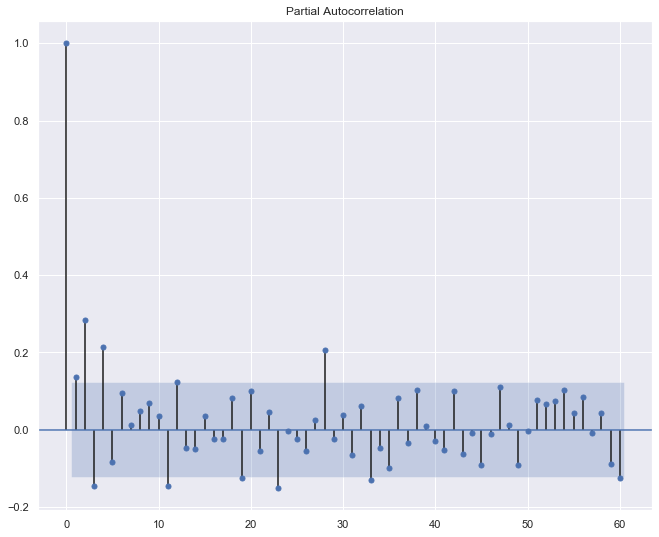

In [235]:
# if do daily forecast, it is hard to find the seasonality even though it has seasonality
plot_acf(np.log(df_train),lags=60)
plot_pacf(np.log(df_train),lags=60)
plt.show()

In [236]:
import pmdarima as pm
results=pm.auto_arima(np.log(df_train),d=0,start_p=1,start_q=1,max_p=2,max_q=2,
                      seasonal=True,m=23,D=0,start_P=0,Start_Q=0,max_P=1,max_Q=1,
                     information_criterion='aic',trace=True,erro_action='ignore',stepwise=True)

Performing stepwise search to minimize aic


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(1,0,1)x(0,0,1,23) [intercept=True]; AIC=252.557, BIC=270.224, Time=1.551 seconds
Fit ARIMA(0,0,0)x(0,0,0,23) [intercept=True]; AIC=276.252, BIC=283.319, Time=0.323 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(1,0,0)x(1,0,0,23) [intercept=True]; AIC=302.513, BIC=316.647, Time=1.750 seconds
Fit ARIMA(0,0,1)x(0,0,1,23) [intercept=True]; AIC=261.960, BIC=276.094, Time=0.279 seconds
Fit ARIMA(0,0,0)x(0,0,0,23) [intercept=False]; AIC=1628.817, BIC=1632.351, Time=0.008 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(1,0,1)x(0,0,0,23) [intercept=True]; AIC=265.735, BIC=279.868, Time=0.338 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(1,0,1)x(1,0,1,23) [intercept=True]; AIC=260.377, BIC=281.577, Time=2.249 seconds
Near non-invertible roots for order (1, 0, 1)(1, 0, 1, 23); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(1,0,1)x(1,0,0,23) [intercept=True]; AIC=388.110, BIC=405.777, Time=1.700 seconds
Fit ARIMA(1,0,0)x(0,0,1,23) [intercept=True]; AIC=258.439, BIC=272.573, Time=0.959 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(2,0,1)x(0,0,1,23) [intercept=True]; AIC=231.724, BIC=252.924, Time=1.846 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(2,0,1)x(0,0,0,23) [intercept=True]; AIC=235.692, BIC=253.359, Time=0.680 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(2,0,1)x(1,0,1,23) [intercept=True]; AIC=258.516, BIC=283.249, Time=2.799 seconds
Near non-invertible roots for order (2, 0, 1)(1, 0, 1, 23); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(2,0,1)x(1,0,0,23) [intercept=True]; AIC=473.779, BIC=494.980, Time=2.091 seconds
Fit ARIMA(2,0,0)x(0,0,1,23) [intercept=True]; AIC=245.360, BIC=263.027, Time=0.722 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(2,0,2)x(0,0,1,23) [intercept=True]; AIC=226.568, BIC=251.301, Time=2.046 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(2,0,2)x(0,0,0,23) [intercept=True]; AIC=230.178, BIC=251.379, Time=0.540 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(2,0,2)x(1,0,1,23) [intercept=True]; AIC=249.361, BIC=277.628, Time=3.431 seconds
Near non-invertible roots for order (2, 0, 2)(1, 0, 1, 23); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(2,0,2)x(1,0,0,23) [intercept=True]; AIC=527.548, BIC=552.282, Time=2.376 seconds
Fit ARIMA(1,0,2)x(0,0,1,23) [intercept=True]; AIC=234.715, BIC=255.915, Time=1.835 seconds
Total fit time: 27.540 seconds


/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [238]:
mod=SARIMAX(np.log(df_train),order=(2, 0, 1),seasonal_order=(0,0,1,23),trend='c')  #value                                
results = mod.fit()

/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


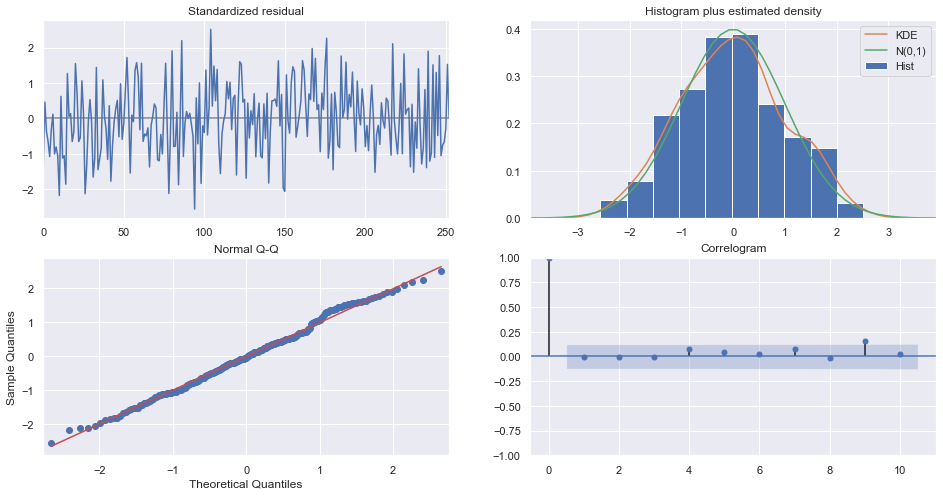

In [239]:
# little residual seanality 
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [240]:
# residual not normally distributed
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                ETS   No. Observations:                  253
Model:             SARIMAX(2, 0, 1)x(0, 0, 1, 23)   Log Likelihood                -109.862
Date:                            Fri, 17 Jul 2020   AIC                            231.724
Time:                                    22:47:08   BIC                            252.924
Sample:                                         0   HQIC                           240.254
                                            - 253                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.0268      0.839      8.376      0.000       5.382       8.671
ar.L1         -0.5308      0.088   

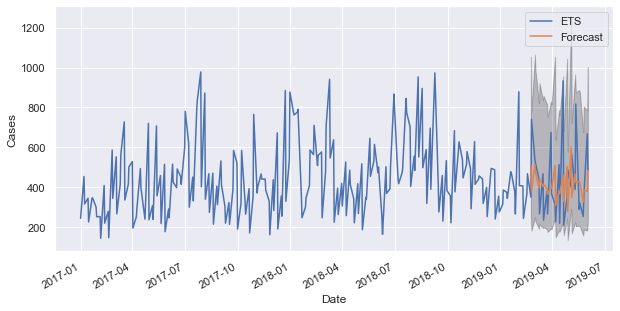

In [245]:
# on step ahead
pred=results.get_prediction(start=-30,dynamic=False)
pred_mean=np.exp(pred.predicted_mean)
pred_ci=np.exp(pred.conf_int())

ax = df_train.plot(label='observed', figsize=(10, 5)) #value
pred_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
plt.legend()
plt.show()

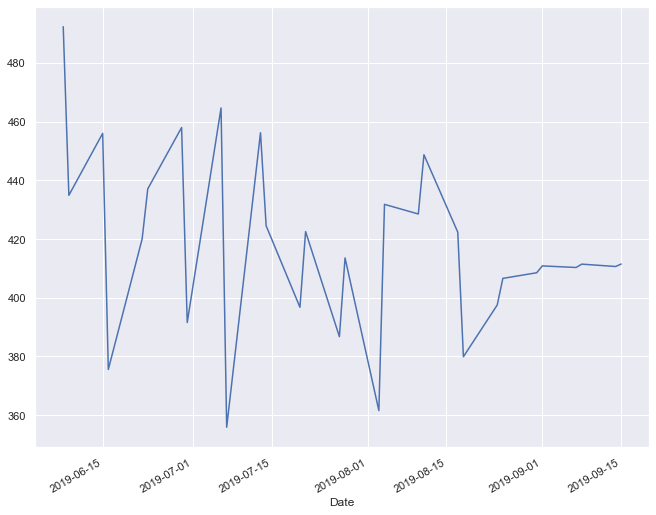

In [261]:
mean_forecast.plot()

In [257]:
print('Forecast Accuracy of: ETS')
accuracy_prod = forecast_accuracy(mean_forecast, df_test.ETS) #f
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: ETS
mape :  1.706
me :  -5.0154
mae :  157.1953
mpe :  1.4825
rmse :  205.8047
corr :  -0.0609
minmax :  0.2921
